# Hardhat (class 0) Summary for YOLO Dataset

This quick notebook scans the YOLO-formatted dataset under `./source/css-data` and reports:
- Total images per split and overall
- Images containing at least one class-0 (hardhat) annotation
- Total number of class-0 boxes
- Percentage of images containing class-0 per split and overall


In [1]:
# Paths and class configuration
from pathlib import Path
import json

# Root of YOLO dataset (contains train/valid/test folders)
data_dir = Path('./source/css-data')

# Target class id we consider "hardhat"
target_class_id = 0

# Supported image extensions
IMG_EXTS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# Optional: verify classes.json if present
classes_path = data_dir / 'classes.json'
class_names = None
if classes_path.exists():
    try:
        class_names = json.loads(classes_path.read_text(encoding='utf-8'))
        if isinstance(class_names, list) and 0 <= target_class_id < len(class_names):
            print(f'Class 0 → {class_names[target_class_id]!r}')
    except Exception as e:
        print('Could not read classes.json:', e)
else:
    print('Note: classes.json not found; assuming class 0 is hardhat.')


In [2]:
# Enumerate label files and count class-0 occurrences
from typing import Dict, List, Tuple

def list_images(images_dir: Path) -> List[Path]:
    files: List[Path] = []
    for ext in IMG_EXTS:
        files.extend(sorted(images_dir.glob(f'*{ext}')))
    return files


def parse_label_file(label_path: Path) -> List[int]:
    """Return list of class ids from a YOLO .txt file (empty list if missing)."""
    if not label_path.exists():
        return []
    cls_ids: List[int] = []
    try:
        with label_path.open('r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                if len(parts) != 5:
                    continue
                try:
                    cls = int(float(parts[0]))
                    cls_ids.append(cls)
                except ValueError:
                    continue
    except Exception:
        # If a file can't be read, treat as empty safely
        return []
    return cls_ids


splits_found: List[str] = []
split_stats: Dict[str, Dict[str, int]] = {}

for split in ['train', 'valid', 'test']:
    images_dir = data_dir / split / 'images'
    labels_dir = data_dir / split / 'labels'
    if not images_dir.exists():
        continue
    splits_found.append(split)

    images = list_images(images_dir)
    total_images = len(images)
    images_with_class0 = 0
    total_instances_class0 = 0

    for img_path in images:
        label_path = labels_dir / (img_path.stem + '.txt')
        cls_ids = parse_label_file(label_path)
        has_class0 = any(c == target_class_id for c in cls_ids)
        if has_class0:
            images_with_class0 += 1
            total_instances_class0 += sum(1 for c in cls_ids if c == target_class_id)

    split_stats[split] = {
        'total_images': total_images,
        'images_with_class0': images_with_class0,
        'total_instances_class0': total_instances_class0,
    }

if not splits_found:
    print('No dataset splits (train/valid/test) were found under', data_dir)
else:
    print('Scanned splits:', ', '.join(splits_found))


Scanned splits: train, valid, test


In [3]:
# Compute and print per-split and global metrics
from math import isfinite

def pct(part: int, whole: int) -> float:
    return (100.0 * part / whole) if whole > 0 else 0.0

# Prepare per-split rows
rows = []
overall_total_images = 0
overall_images_with_class0 = 0
overall_instances_class0 = 0

for split in ['train', 'valid', 'test']:
    stats = split_stats.get(split)
    if not stats:
        continue
    ti = int(stats['total_images'])
    iw = int(stats['images_with_class0'])
    ii = int(stats['total_instances_class0'])
    rows.append((split, ti, iw, pct(iw, ti), ii))
    overall_total_images += ti
    overall_images_with_class0 += iw
    overall_instances_class0 += ii

# Print formatted table
print('\nHardhat (class 0) summary by split:')
print('-' * 70)
print(f"{'split':<10} {'total_images':>13} {'images_with_0':>15} {'pct_with_0':>12} {'instances_0':>13}")
print('-' * 70)
for split, ti, iw, p, ii in rows:
    print(f"{split:<10} {ti:>13} {iw:>15} {p:>11.2f}% {ii:>13}")
print('-' * 70)
print(f"{'GLOBAL':<10} {overall_total_images:>13} {overall_images_with_class0:>15} {pct(overall_images_with_class0, overall_total_images):>11.2f}% {overall_instances_class0:>13}")



Hardhat (class 0) summary by split:
----------------------------------------------------------------------
split       total_images   images_with_0   pct_with_0   instances_0
----------------------------------------------------------------------
train               2605            1314       50.44%          3145
valid                114              42       36.84%            79
test                  82              30       36.59%           110
----------------------------------------------------------------------
GLOBAL              2801            1386       49.48%          3334


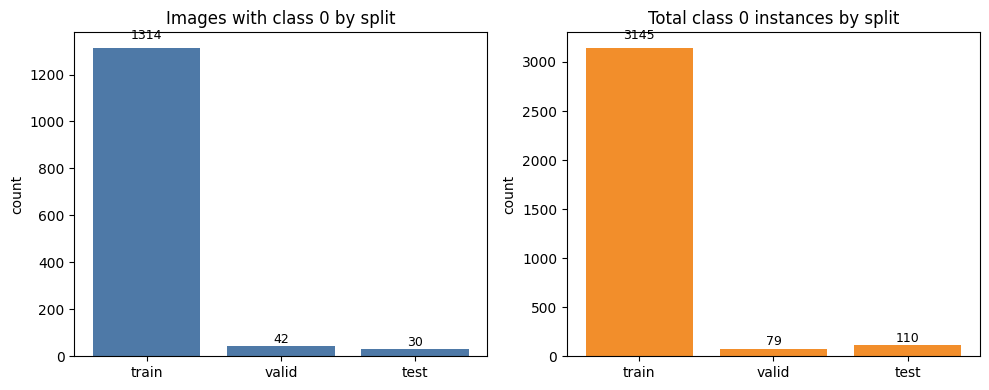

In [4]:
# Optional plots: images_with_class0 and total_instances_class0 by split
import matplotlib.pyplot as plt
import numpy as np

splits = [s for s in ['train', 'valid', 'test'] if s in split_stats]
if splits:
    imgs_with = [split_stats[s]['images_with_class0'] for s in splits]
    inst_cnt = [split_stats[s]['total_instances_class0'] for s in splits]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Plot 1: images with class 0
    ax = axes[0]
    ax.bar(splits, imgs_with, color='#4e79a7')
    ax.set_title('Images with class 0 by split')
    ax.set_ylabel('count')
    for i, v in enumerate(imgs_with):
        ax.text(i, v + max(1, v)*0.02, str(v), ha='center', va='bottom', fontsize=9)

    # Plot 2: total class 0 instances
    ax = axes[1]
    ax.bar(splits, inst_cnt, color='#f28e2b')
    ax.set_title('Total class 0 instances by split')
    ax.set_ylabel('count')
    for i, v in enumerate(inst_cnt):
        ax.text(i, v + max(1, v)*0.02, str(v), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()
else:
    print('No splits found to plot.')
